# 4.0 ETL (Data Cleaning and Integration)
This section describes the Extract, Transform, and Load (ETL) process used to prepare the air quality and meteorological datasets for integrated analysis and modelling.
It will also handle the second research objective: Clustering Weather Regimes and Air Quality Risk Indicators.

### 4.1 Data Harmonisation
Before merging, both datasets are harmonised to ensure consistency in temporal resolution, variable naming, and data types.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

In [2]:
weather_df = pd.read_csv("../datasets/weather_df.csv")
aq_df = pd.read_csv("../datasets/air_quality_df.csv")

In [3]:
# load weather variables data
weather_df.dtypes

date                     object
temperature_2m          float64
relative_humidity_2m    float64
precipitation           float64
wind_speed_10m          float64
surface_pressure        float64
city                     object
country                  object
lat                     float64
lon                     float64
dtype: object

In [4]:
aq_df.dtypes

date                 object
pm10                float64
pm2_5               float64
carbon_monoxide     float64
sulphur_dioxide     float64
ozone               float64
us_aqi              float64
carbon_dioxide      float64
nitrogen_dioxide    float64
city                 object
country              object
lat                 float64
lon                 float64
dtype: object

### 4.1.1 Clean & Prepare Each Dataset
- a) Weather forecast variables dataset

In [5]:
# Weather dataset
weather_df['date'] = pd.to_datetime(weather_df['date']) # change to datetime
weather_df['date_day'] = weather_df['date'].dt.date # create new column date_day
weather_df['hour'] = weather_df['date'].dt.hour #create new column hour

weather_df.head(3)


,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,city,country,lat,lon,date_day,hour
0,2025-11-07 00:00:00+00:00,18.7575,77.0,0.0,6.696387,1006.03955,Los Angeles,US,34.0522,-118.2437,2025-11-07,0
1,2025-11-07 01:00:00+00:00,17.6075,84.0,0.0,5.116561,1006.09620,Los Angeles,US,34.0522,-118.2437,2025-11-07,1
2,2025-11-07 02:00:00+00:00,16.7575,89.0,0.0,2.811690,1005.86676,Los Angeles,US,34.0522,-118.2437,2025-11-07,2


- b) Air quality variables

In [6]:
# Air quality dataset 
aq_df['date'] = pd.to_datetime(aq_df['date'])
aq_df['date_day'] = aq_df['date'].dt.date
aq_df['hour'] = aq_df['date'].dt.hour
aq_df.head(2)


,date,pm10,pm2_5,carbon_monoxide,sulphur_dioxide,ozone,us_aqi,carbon_dioxide,nitrogen_dioxide,city,country,lat,lon,date_day,hour
0,2025-11-07 00:00:00+00:00,12.3,11.8,252.0,15.1,57.0,103.125000,466.0,29.5,Los Angeles,US,34.0522,-118.2437,2025-11-07,0
1,2025-11-07 01:00:00+00:00,13.5,12.6,307.0,13.5,43.0,102.239586,472.0,38.9,Los Angeles,US,34.0522,-118.2437,2025-11-07,1


### 4.1.2 Merge the datasets
We merge on city and date_day (aggregated daily) so that each row contains both weather and air quality data for that city and day. The aggregation to daily means is to reduce short-term noise and improve the stability and interpretability of clustering and predictive models.

#### Define numeric columns explicitly
#### Air quality 
#### step 1: Create air quality numeric columns

In [7]:
# create air quality numeric columns
aq_numeric_cols = [
    "pm2_5", "pm10", "us_aqi", "ozone",
    "nitrogen_dioxide", "sulphur_dioxide",
    "carbon_monoxide", "carbon_dioxide"
]

# create air quality numeric columns
weather_numeric_cols = [
    "temperature_2m",
    "relative_humidity_2m",
    "precipitation",
    "wind_speed_10m",
    "surface_pressure"
]


#### step 2: Aggregate ONLY numeric columns

In [12]:
aq_daily = (
    aq_df
    .groupby(["city", "date_day"])[aq_numeric_cols]
    .mean()
    .reset_index()
)

weather_daily = (
    weather_df
    .groupby(["city", "date_day"])[weather_numeric_cols]
    .mean()
    .reset_index()
)
# Merge the two
merged_df = pd.merge(aq_daily, weather_daily, on=['city', 'date_day'], how='inner')
merged_df.dtypes

city                     object
date_day                 object
pm2_5                   float64
pm10                    float64
us_aqi                  float64
ozone                   float64
nitrogen_dioxide        float64
sulphur_dioxide         float64
carbon_monoxide         float64
carbon_dioxide          float64
temperature_2m          float64
relative_humidity_2m    float64
precipitation           float64
wind_speed_10m          float64
surface_pressure        float64
dtype: object

In [15]:
# Create a daily datetime column (datetime64[ns]) for aggregation and time-based analysis
# Using floor('D') preserves temporal ordering and avoids object-type dates
merged_df['date_day'] = pd.to_datetime(merged_df['date_day'])
merged_df.dtypes


city                            object
date_day                datetime64[ns]
pm2_5                          float64
pm10                           float64
us_aqi                         float64
ozone                          float64
nitrogen_dioxide               float64
sulphur_dioxide                float64
carbon_monoxide                float64
carbon_dioxide                 float64
temperature_2m                 float64
relative_humidity_2m           float64
precipitation                  float64
wind_speed_10m                 float64
surface_pressure               float64
dtype: object

#### step 3: Create a location lookup table (one-time)

In [16]:
# Create location lookup for reference of city, 'country', lat and lon during dashboards
location_lookup = (
    weather_df[['city', 'country', 'lat', 'lon']]
    .drop_duplicates()
    .reset_index(drop=True)
)


### 4.2.1 Exploratory Data Analysis

This section explores relationships between meteorological variables and air quality indicators prior to clustering and predictive modelling. Scatter plots are used to identify monotonic, non-linear, or threshold-based relationships that may inform feature selection and clustering structure.
Exploratory analysis is conducted at the daily level to balance interpretability, noise reduction, and regime-level pattern detection.
Air quality target proxies (PM2.5 and US AQI) are used as anchors due to their relevance and influence on air quality as per the WHO. Selected proxies minimise clutter in plots

Insights from this exploratory step guide:
- Feature scaling decisions
- Clustering suitability
- Selection of correlation metrics (Spearman) (Not necessary at this step)
- Interpretation of cluster regimes
#### i) Plot PM2.5 vs key weather drivers


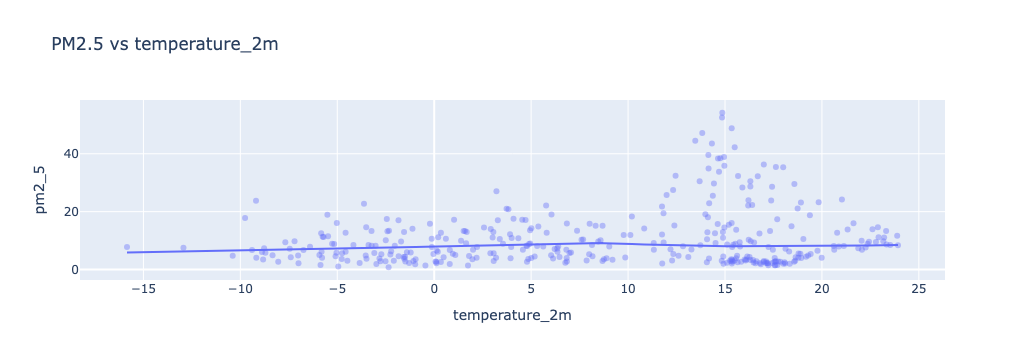

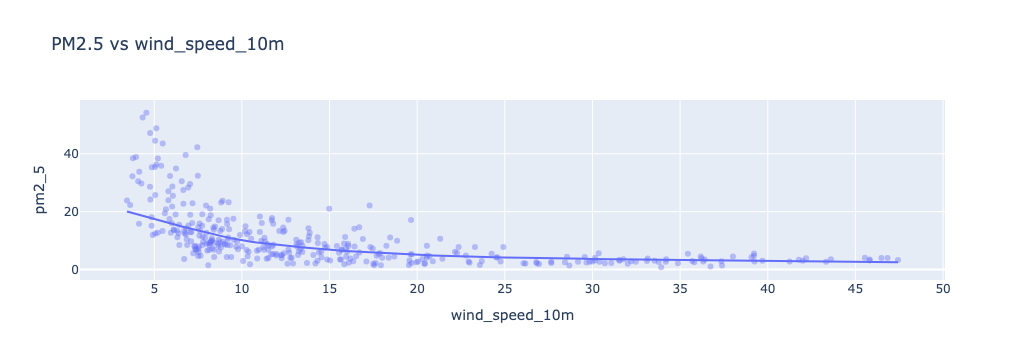

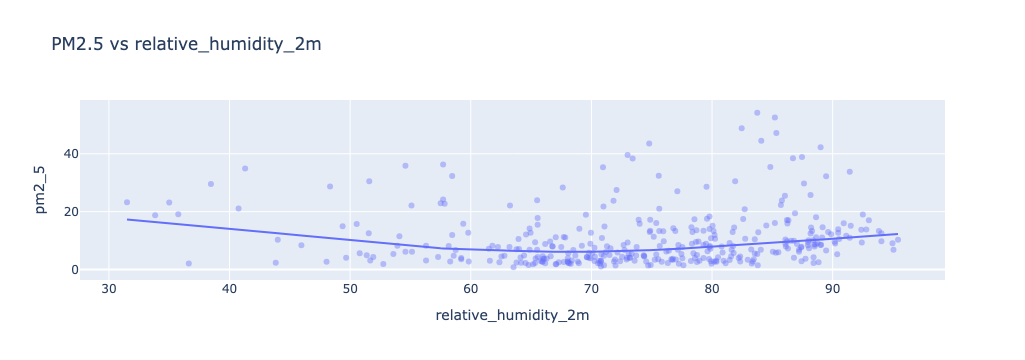

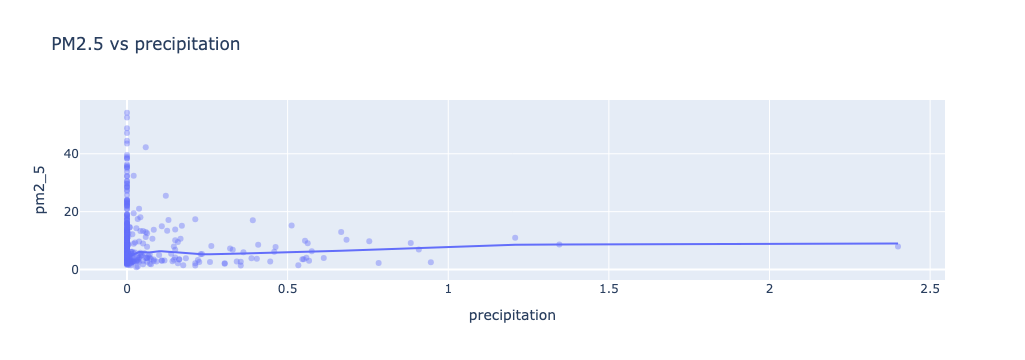

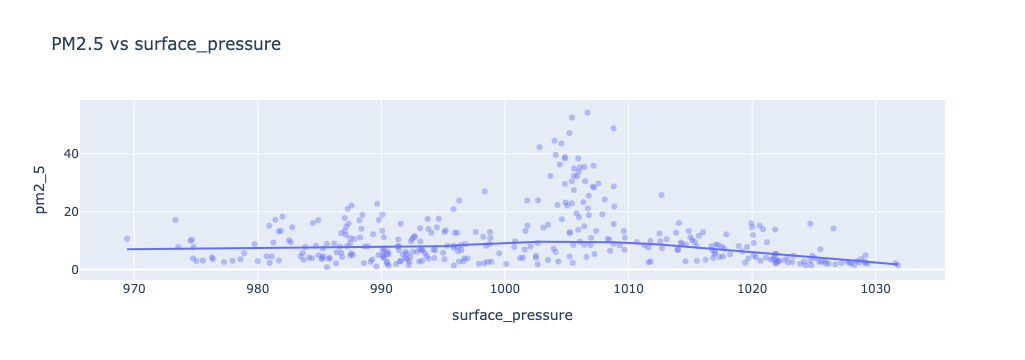

In [17]:
import plotly.express as px

weather_vars = [
    'temperature_2m',
    'wind_speed_10m',
    'relative_humidity_2m',
    'precipitation',
    'surface_pressure'
]

for var in weather_vars:
    fig = px.scatter(
        merged_df,
        x=var,
        y='pm2_5',
        opacity=0.4,
        title=f'PM2.5 vs {var}',
        trendline='lowess'
    )
    fig.show()


#### ii) Plot US AQI vs dispersion controls (Critical for Risk)
Critical to also have a look at wind speed and precipitation for dispersion aspects of weather

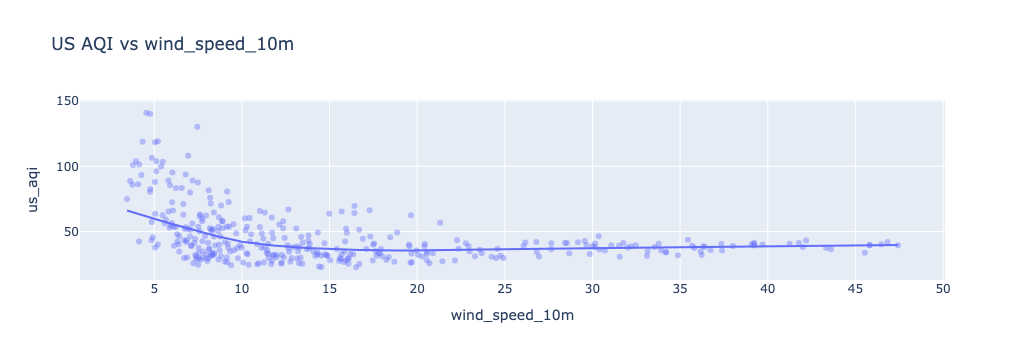

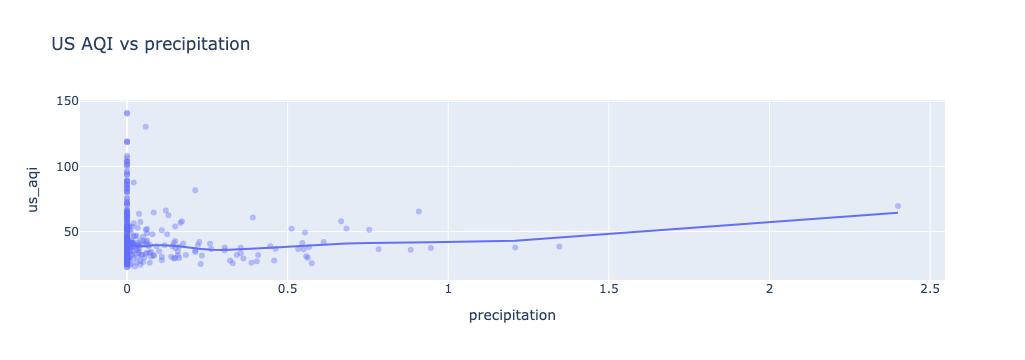

In [18]:
for var in ['wind_speed_10m', 'precipitation']:
    fig = px.scatter(
        merged_df,
        x=var,
        y='us_aqi',
        opacity=0.4,
        title=f'US AQI vs {var}',
        trendline='lowess'
    )
    fig.show()


## Clustering Readiness Assessment

Prior to applying unsupervised learning, scatter plots were examined to assess whether the data exhibits structured, non-random behaviour and whether meaningful environmental regimes may exist.

### Evidence of Non-Random Structure

Scatter plots between PM2.5, US AQI, and meteorological variables reveal clear, physically interpretable patterns. PM2.5 displays a non-linear relationship with temperature, increasing up to moderate temperatures before declining at higher values. Wind speed exhibits a strong dispersive effect, with pollutant concentrations peaking at low wind speeds and decreasing rapidly thereafter. Relative humidity shows a monotonic increase in PM2.5, consistent with hygroscopic particle growth. Precipitation demonstrates a strong threshold effect, with sharp reductions in PM2.5 following even minimal rainfall. Surface pressure exhibits a non-linear pattern associated with atmospheric stability and inversion conditions.

These consistent trends indicate structured behaviour rather than random noise, satisfying a key requirement for clustering analysis.

### Overlapping but Separable Regimes

While the scatter plots do not show sharply bounded clusters, they exhibit dense regions, curved relationships, and threshold-driven transitions. Such overlapping but structured distributions are characteristic of environmental systems influenced by multiple interacting processes. The presence of gradual regime transitions supports the use of unsupervised learning to identify dominant weather–air quality regimes without assuming strict separability.

Based on these observations, the dataset is considered suitable for clustering to identify meaningful weather and air quality risk regimes.


 # Environmental data frequently violate linearity and normality assumptions; therefore, non-parametric trends are prioritised over parametric regression fits.